In [1]:
import pandas as pd
import numpy as np

In [2]:
adj = pd.read_csv('adj.txt', header=None)
# make adj matrix
adj_matrix = np.zeros((len(adj),len(adj)))
for i in range(len(adj)):
    for j in range(len(adj)):
        if i == j:
            continue
        if str(j) in adj.iloc[i,0].split(' '):
            adj_matrix[i,j] = 1
            adj_matrix[j,i] = 1
# label            
label = np.loadtxt('karate_label.txt')

In [3]:
adj_matrix

array([[0., 1., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [6]:
from matrixFac import MF
from deepWalk import DeepWalk
from deepWalkHier import DeepWalkHier


In [68]:
# Matrix Factorization
MF_model = MF(embedding_dim=2, learning_rate=0.005, n_iter=300, adj_matrix=adj_matrix)
MF_model.train()
MF_emb = MF_model.show_embedding()

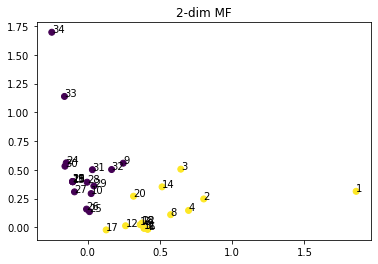

In [69]:
import matplotlib.pyplot as plt
plt.title('2-dim MF')
plt.scatter(MF_emb[:,0],MF_emb[:,1], c=list(map(int, label[:,1])))
for i in range(0, 34):
        plt.text(float(MF_emb[i,0]), float(MF_emb[i,1]), i+1 , fontsize=10)
plt.show()

In [70]:
# DeepWalk with softmax
# consider epoch as walks_per_vertex
DeepWalk_model = DeepWalk(adj_matrix, embedding_dim=2, walks_per_vertex=5,
                          walk_len=10, window_size=3, learning_rate=0.05)

DeepWalk_loss = DeepWalk_model.train()
DeepWalk_emb, _ = DeepWalk_model.show_embedding()

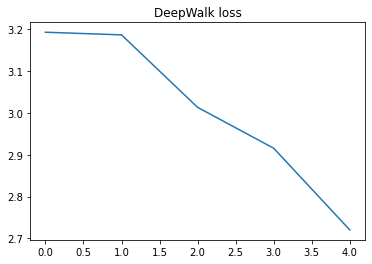

In [71]:
import matplotlib.pyplot as plt
plt.title('DeepWalk loss')
plt.plot(DeepWalk_loss)

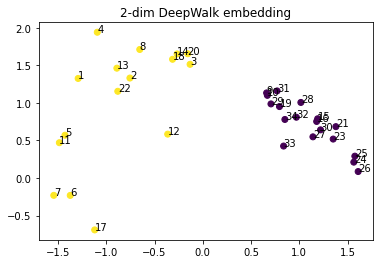

In [72]:
plt.title('2-dim DeepWalk embedding')
plt.scatter(DeepWalk_emb[:,0],DeepWalk_emb[:,1], c=list(map(int, label[:,1])))
for i in range(0, 34):
        plt.text(float(DeepWalk_emb[i,0]), float(DeepWalk_emb[i,1]), i+1 , fontsize=10)
plt.show()

In [65]:
# DeepWalk with hierarchiy
DeepWalkHier_model = DeepWalkHier(adj_matrix, embedding_dim=2, walks_per_vertex=5,
                                  walk_len=10, window_size=3, learning_rate=0.02)
DeepWalkHier_loss = DeepWalkHier_model.train()
DeepWalkHier_emb = DeepWalkHier_model.show_embedding()

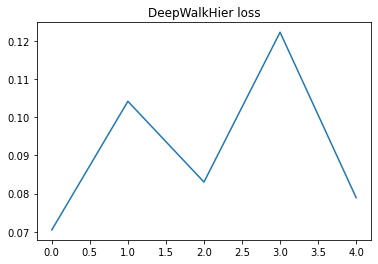

In [66]:
import matplotlib.pyplot as plt
plt.title('DeepWalkHier loss')
plt.plot(DeepWalkHier_loss)

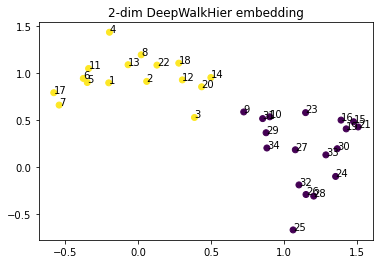

In [73]:
plt.title('2-dim DeepWalkHier embedding')
plt.scatter(DeepWalkHier_emb[:,0],DeepWalkHier_emb[:,1], c=list(map(int, label[:,1])))
for i in range(0, 34):
        plt.text(float(DeepWalkHier_emb[i,0]), float(DeepWalkHier_emb[i,1]), i+1 , fontsize=10)
plt.show()

# Classification 

In [125]:
train_ratio = [0.07, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65]

In [126]:
f1_result = pd.DataFrame()
f1_result['ratio'] = train_ratio
f1_result['MF'] = 0
f1_result['DeepWalk'] = 0
f1_result['DeepWalk hier'] = 0

In [127]:
f1_result

,ratio,MF,DeepWalk,DeepWalk hier
0,0.07,0,0,0
1,0.15,0,0,0
2,0.25,0,0,0
3,0.35,0,0,0
4,0.45,0,0,0
5,0.55,0,0,0
6,0.65,0,0,0


In [128]:
emb_dic = {}
emb_dic['MF'] = MF_emb
emb_dic['DeepWalk'] = DeepWalk_emb 
emb_dic['DeepWalk hier'] = DeepWalkHier_emb 

In [134]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

for model in ['MF','DeepWalk','DeepWalk hier']:
    test_result = []
    f1_scores = [0]*10
    for tr in train_ratio :
        # try 10 times 
        for i in range(0,10):
            X_train, X_test, y_train, y_test = train_test_split(
                emb_dic[model], label[:,1],
                train_size=tr,
                stratify=label[:,1]
            )

            cls_model = LogisticRegression()
            cls_model.fit(X_train, y_train)
            y_pred = cls_model.predict(X_test)

            f1_scores[i] = f1_score(y_test, y_pred, average='binary')
        # average f1 score for catch the randomness
        test_result.append(np.mean(f1_scores))
    f1_result[model] = test_result

In [136]:
f1_result

,ratio,MF,DeepWalk,DeepWalk hier
0,0.07,0.866476,0.934597,0.942415
1,0.15,0.304226,0.915911,0.920234
2,0.25,0.975264,0.970909,0.988000
3,0.35,0.960476,0.995238,0.990476
4,0.45,0.976471,1.000000,0.994118
5,0.55,0.958095,1.000000,0.973333
6,0.65,0.963636,1.000000,1.000000
